In [1]:
import pymongo
import json
import requests
import datetime

import matplotlib.pyplot as plt

from pymongo import MongoClient

SHOW = True
WDS = [
    ('b33e77f31fe04969803d8c93eee90701','41204679123'),
    ('b33e77f31fe04969803d8c93eee90701','41204679138'),
    ('b33e77f31fe04969803d8c93eee90701','41204679141'),
    ('b33e77f31fe04969803d8c93eee90701','52066904374'),
    ('99f34fe1ac3c472ca60f67296f2dabed','51851122225'),
    ('99f34fe1ac3c472ca60f67296f2dabed','51683066718'),
    ('99f34fe1ac3c472ca60f67296f2dabed','52549511179'),
    ('99f34fe1ac3c472ca60f67296f2dabed','51683066700'),
    ('99f34fe1ac3c472ca60f67296f2dabed','52549510906'),
]

def get_rank(appid, kid, date_str):
    date = date_str.split()[0]
    url = 'http://www.yushanapp.com/baiduapi/kwrank/%s/json/%s/%s/%s' % (appid,kid,date,date)
    #print(url)
    r = requests.get(url)
    data = r.json()
    data_l = data['kws']
    
    for d in data_l:
        if d['date'] == date_str:
            return d['kpis']
    return []
#a = get_rank('b33e77f31fe04969803d8c93eee90701','41204679123','2016-10-08 10')
#print(a)



In [4]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

with MongoClient('mongodb://101.200.174.136:10222') as client:
    client.yushan.authenticate('yushan','yushan')
    db = client.yushan
    c = db['baidu_fjcy']
    tmp = c.find_one()
    pp.pprint(tmp)
    #print(json.dumps(c.find_one(), indent=4))

{   '_id': ObjectId('57e4fcdf02f2bb1004b01a8b'),
    'app_id': 'b33e77f31fe04969803d8c93eee90701',
    'date': datetime.datetime(2016, 9, 23, 9, 58, 54, 577000),
    'fujia_path': 'Z:\\wh\\fujia_report\\b33e77f31fe04969803d8c93eee90701\\creative_20160923-20160923_38545.csv',
    'fujia_report': {   'button': {   'App推广': '高德地图',
                                      '关键词': '导航下载',
                                      '展现': 6065,
                                      '平均点击价格': 1.11,
                                      '推广单元': '软件-下载',
                                      '推广计划': 'zt-量级词-71',
                                      '日期': '2016-09-23',
                                      '消费': 2117.25,
                                      '点击': 1902,
                                      '点击率': '31.36%',
                                      '系统类型': 'Android',
                                      '账户': 'Baidu-无线bc-智投y2160884'},
                        'h5': {   'App推广': '标题',
      

导航下载 2016-09-27 14:13:02 1.1 6509 1966 2028.42 30.20% 1.03 ['651', '88', '6', '0', '745'] 10
导航下载 2016-09-27 14:40:20 1.1 7026 2130 2181.26 30.32% 1.02 ['271', '41', '4', '0', '316'] 10
导航下载 2016-09-27 15:31:48 1.1 7507 2291 2396.35 30.52% 1.05 ['1', '0', '0', '0', '1'] 10
导航下载 2016-10-08 10:06:35 1.2 1049 312 416.32 29.74% 1.33 ['134', '10', '0', '0', '144'] 10
导航下载 2016-10-08 11:25:35 1.2 1313 396 524.46 30.16% 1.32 ['195', '11', '0', '0', '206'] 10
导航下载 2016-10-08 11:50:30 1.2 1533 480 603.42 31.31% 1.26 ['106', '3', '0', '0', '109'] 10
导航下载 2016-10-08 12:10:30 1.1 1664 533 651.13 32.03% 1.22 ['109', '3', '0', '0', '112'] 10
导航下载 2016-10-08 12:50:29 1.2 1664 538 656.08 32.33% 1.22 ['109', '3', '0', '0', '112'] 10
导航下载 2016-10-08 13:15:11 1.3 1664 538 656.08 32.33% 1.22 ['109', '3', '0', '0', '112'] 10
导航下载 2016-10-08 13:47:00 1.3 1664 538 656.08 32.33% 1.22 ['109', '3', '0', '0', '112'] 10
导航下载 2016-10-08 14:27:00 1.3 1664 538 656.08 32.33% 1.22 ['0', '0', '0', '0', '0'] 10
导航下载 201

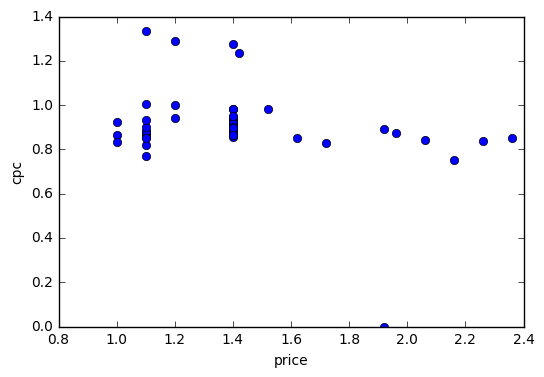

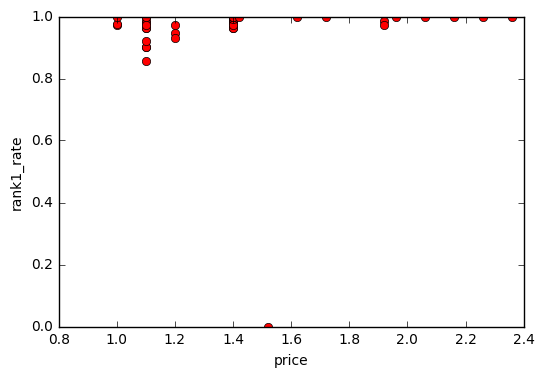

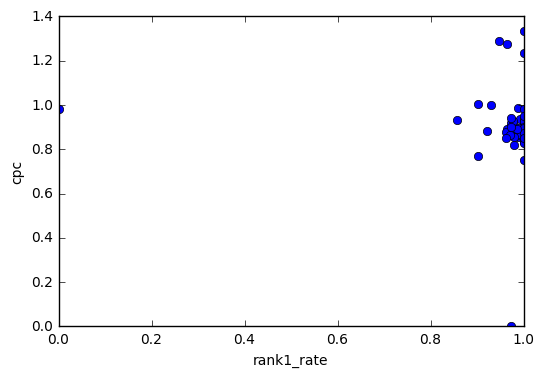

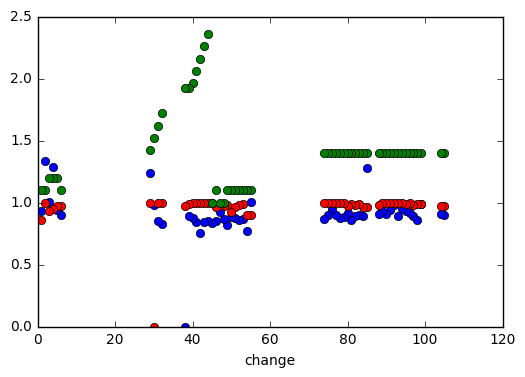

语音导航 2016-10-10 17:42:31 1 1764 774 744.33 43.88% 0.96 ['0', '0', '0', '0', '0'] 9
语音导航 2016-10-11 09:22:38 1 636 255 240.8 40.09% 0.94 ['201', '12', '2', '0', '215'] 9
语音导航 2016-10-11 09:48:56 1 755 297 280.75 39.34% 0.95 ['75', '1', '1', '0', '77'] 9
语音导航 2016-10-11 10:28:56 1 870 367 347.82 42.18% 0.95 ['1', '0', '0', '0', '1'] 9
语音导航 2016-10-11 10:48:56 1.1 988 420 397.2 42.51% 0.95 ['78', '7', '0', '0', '85'] 9
语音导航 2016-10-11 11:28:56 1.2 1114 474 446.6 42.55% 0.94 ['8', '0', '0', '0', '8'] 9
语音导航 2016-10-11 12:08:56 1.3 1282 543 511.75 42.36% 0.94 ['190', '5', '1', '0', '196'] 9
语音导航 2016-10-11 12:28:56 1.4 1422 610 573.55 42.90% 0.94 ['13', '0', '0', '0', '13'] 9
语音导航 2016-10-11 13:08:56 1.5 1549 670 630.68 43.25% 0.94 ['130', '3', '0', '0', '133'] 9
语音导航 2016-10-11 13:28:57 1.6 1753 752 706.96 42.90% 0.94 ['20', '0', '0', '0', '20'] 9
语音导航 2016-10-11 14:08:56 1.7 1872 812 765.17 43.38% 0.94 ['187', '5', '0', '0', '192'] 9
语音导航 2016-10-11 14:48:57 1.8 1966 853 804.03 43.39% 0.9

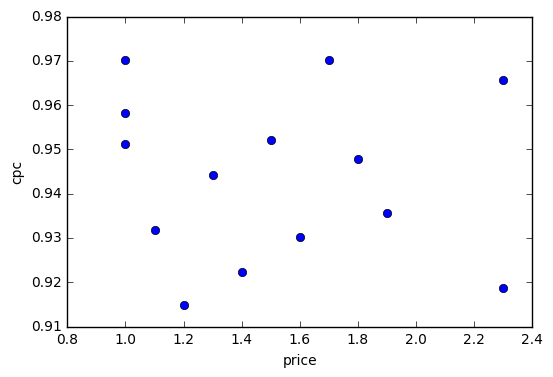

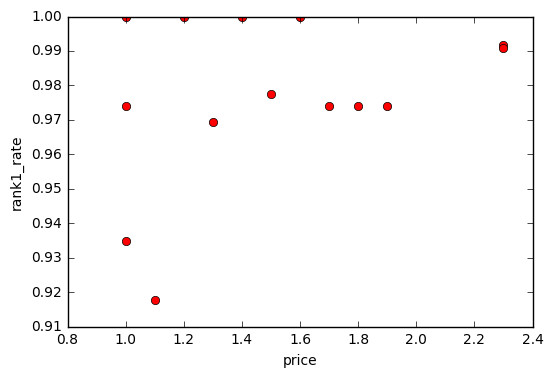

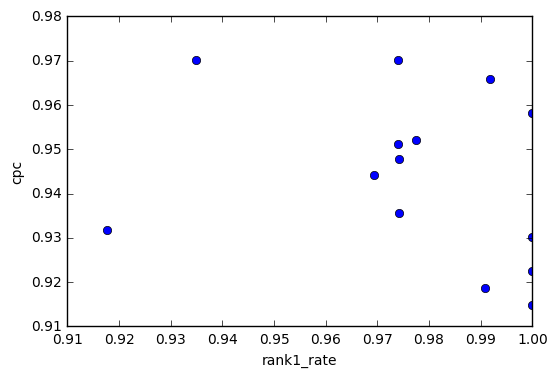

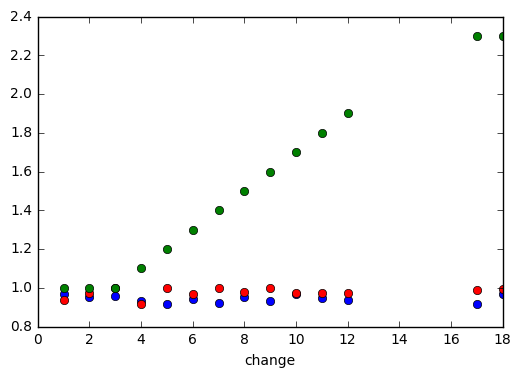

手机导航 2016-10-10 17:42:31 0.8 2681 820 668.05 30.59% 0.81 ['0', '0', '0', '0', '0'] 10
手机导航 2016-10-11 09:22:38 0.8 987 268 214.89 27.15% 0.8 ['251', '13', '2', '0', '266'] 10
手机导航 2016-10-11 09:48:56 0.8 1155 313 251.08 27.10% 0.8 ['101', '9', '0', '0', '110'] 10
手机导航 2016-10-11 10:28:56 0.8 1327 371 296.83 27.96% 0.8 ['8', '0', '0', '0', '8'] 10
手机导航 2016-10-11 10:48:56 0.9 1502 425 339.27 28.30% 0.8 ['109', '5', '2', '0', '116'] 10
手机导航 2016-10-11 11:28:56 1 1739 497 399.9 28.58% 0.8 ['19', '2', '0', '0', '21'] 10
手机导航 2016-10-11 12:08:56 1.1 2026 584 470.6 28.83% 0.81 ['321', '13', '3', '0', '337'] 10
手机导航 2016-10-11 12:28:58 1.2 2287 660 533.3 28.86% 0.81 ['20', '2', '0', '0', '22'] 10
手机导航 2016-10-11 13:08:56 1.3 2546 732 597.34 28.75% 0.82 ['294', '10', '3', '0', '307'] 10
手机导航 2016-10-11 13:28:57 1.4 3043 885 746.99 29.08% 0.84 ['46', '0', '1', '0', '47'] 10
手机导航 2016-10-11 14:08:56 1.5 3410 988 851.37 28.97% 0.86 ['446', '10', '2', '0', '458'] 10
手机导航 2016-10-11 14:48:57 1.6 35

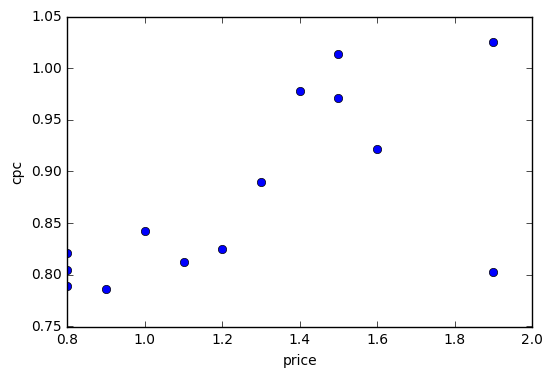

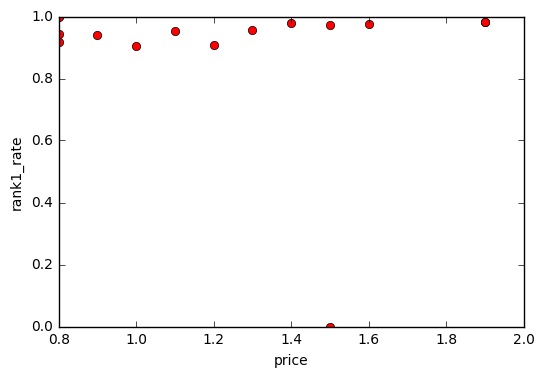

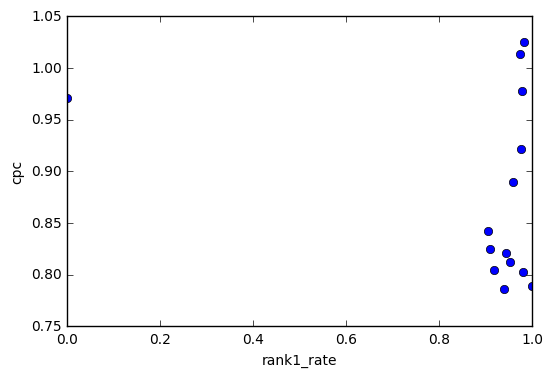

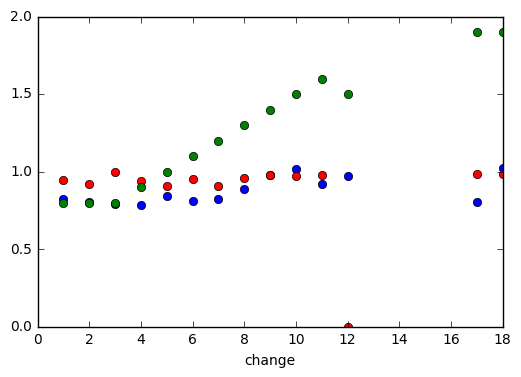

导航地图下载 2016-10-10 17:42:31 1.2 1593 402 645.02 25.24% 1.6 ['19', '2', '0', '0', '21'] 10
导航地图下载 2016-10-11 09:22:38 1.2 642 143 206.43 22.27% 1.44 ['1', '0', '0', '0', '1'] 10
导航地图下载 2016-10-11 09:48:56 1.2 735 174 252.66 23.67% 1.45 ['34', '6', '0', '0', '40'] 10
导航地图下载 2016-10-11 10:28:56 1.2 821 193 282.24 23.51% 1.46 ['0', '0', '0', '0', '0'] 10
导航地图下载 2016-10-11 10:48:56 1.1 907 216 316.28 23.81% 1.46 ['31', '13', '0', '0', '44'] 10
导航地图下载 2016-10-11 11:28:56 1 954 233 343.33 24.42% 1.47 ['0', '0', '0', '0', '0'] 10
导航地图下载 2016-10-11 12:08:56 0.9 965 238 350.47 24.66% 1.47 ['4', '2', '0', '0', '6'] 10
导航地图下载 2016-10-11 12:28:56 0.8 969 241 355.88 24.87% 1.48 ['4', '2', '0', '0', '6'] 10
导航地图下载 2016-10-11 13:08:56 0.7 969 241 355.88 24.87% 1.48 ['1', '0', '0', '0', '1'] 10
导航地图下载 2016-10-11 13:28:57 0.7 971 242 357.28 24.92% 1.48 ['2', '0', '0', '0', '2'] 10
导航地图下载 2016-10-11 14:08:56 0.74 971 242 357.28 24.92% 1.48 ['2', '0', '0', '0', '2'] 10
导航地图下载 2016-10-11 14:48:57 0.74 971 2

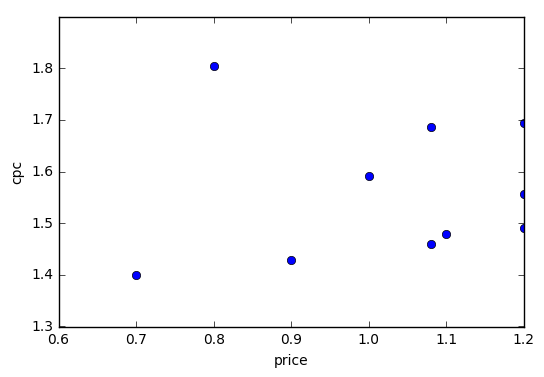

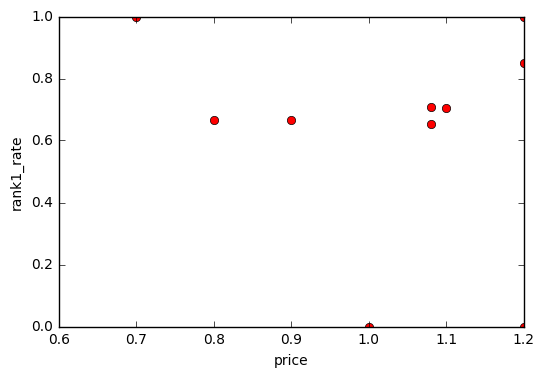

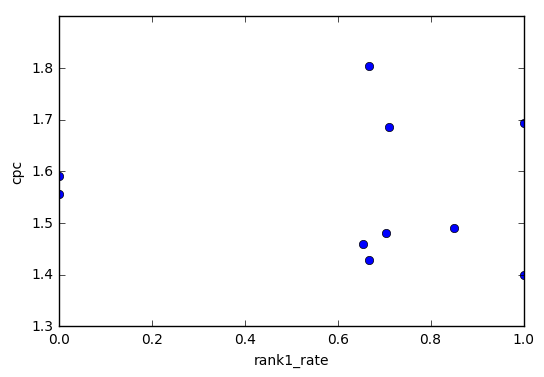

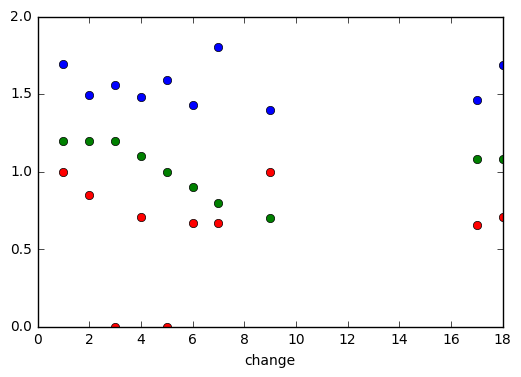

有信电话免费下载 2016-10-10 17:42:31 1.34 634 220 221.87 34.70% 1.01 ['14', '0', '0', '0', '14'] 10
有信电话免费下载 2016-10-11 09:22:38 1.34 182 64 57.13 35.16% 0.89 ['41', '0', '0', '0', '41'] 10
有信电话免费下载 2016-10-11 09:48:56 1.34 227 73 65.19 32.16% 0.89 ['16', '0', '0', '0', '16'] 10
有信电话免费下载 2016-10-11 10:28:56 1.34 250 81 72.58 32.40% 0.9 ['7', '0', '0', '0', '7'] 10
有信电话免费下载 2016-10-11 11:08:56 1.44 288 95 85.94 32.99% 0.9 ['50', '0', '0', '0', '50'] 10
有信电话免费下载 2016-10-11 11:28:56 1.54 327 107 96.29 32.72% 0.9 ['9', '0', '0', '0', '9'] 10
有信电话免费下载 2016-10-11 12:08:57 1.64 363 123 110.92 33.88% 0.9 ['48', '1', '0', '0', '49'] 10
有信电话免费下载 2016-10-11 12:28:56 1.74 393 133 118.85 33.84% 0.89 ['7', '0', '0', '0', '7'] 10
有信电话免费下载 2016-10-11 13:08:56 1.84 429 142 126.8 33.10% 0.89 ['30', '0', '0', '0', '30'] 10
有信电话免费下载 2016-10-11 13:28:57 1.94 472 155 139.13 32.84% 0.9 ['3', '0', '0', '0', '3'] 10
有信电话免费下载 2016-10-11 14:08:56 2.04 520 178 158.98 34.23% 0.89 ['45', '2', '0', '0', '47'] 10
有信电话免费下载 20

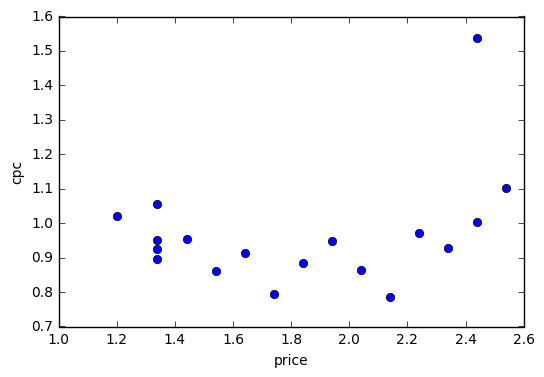

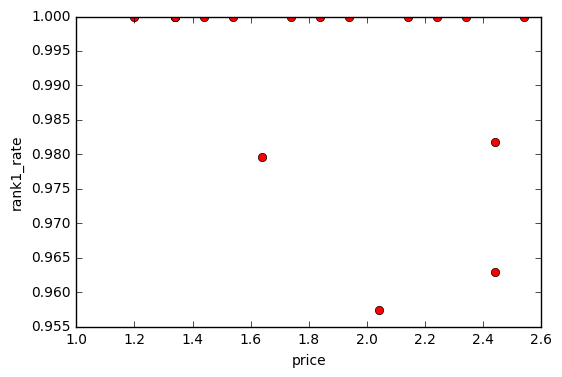

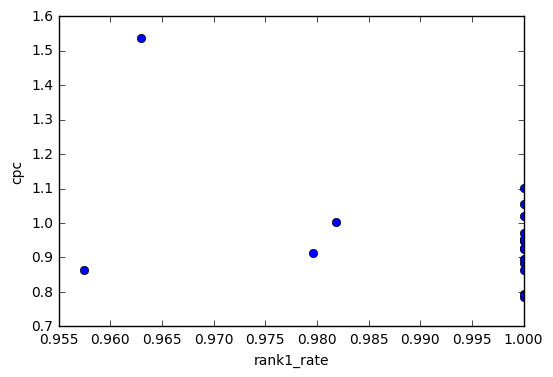

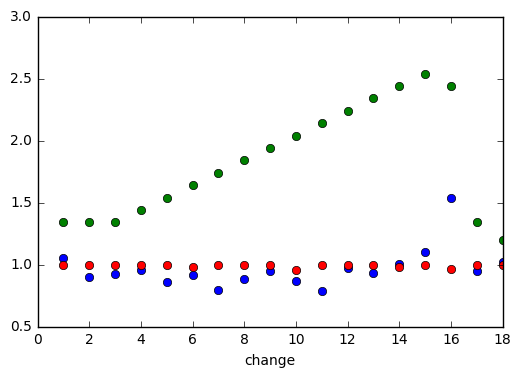

微会下载打电话免费 2016-10-10 17:42:31 1.5 268 77 113.17 28.73% 1.47 ['5', '2', '0', '0', '7'] 10
微会下载打电话免费 2016-10-11 09:22:38 1.5 68 21 26.3 30.88% 1.25 ['19', '0', '0', '0', '19'] 10
微会下载打电话免费 2016-10-11 09:48:56 1.5 94 27 33.11 28.72% 1.23 ['9', '0', '0', '0', '9'] 10
微会下载打电话免费 2016-10-11 10:28:56 1.5 102 32 38.46 31.37% 1.2 ['5', '0', '0', '0', '5'] 10
微会下载打电话免费 2016-10-11 11:08:56 1.4 116 37 43.46 31.90% 1.17 ['13', '0', '1', '0', '14'] 10
微会下载打电话免费 2016-10-11 11:28:56 1.3 125 42 50.01 33.60% 1.19 ['2', '0', '0', '0', '2'] 10
微会下载打电话免费 2016-10-11 12:08:56 1.2 132 45 53.55 34.09% 1.19 ['8', '0', '0', '0', '8'] 10
微会下载打电话免费 2016-10-11 12:28:56 1.1 136 45 53.55 33.09% 1.19 ['2', '0', '0', '0', '2'] 10
微会下载打电话免费 2016-10-11 13:08:57 1.1 150 46 55 30.67% 1.2 ['12', '0', '0', '0', '12'] 10
微会下载打电话免费 2016-10-11 13:28:57 1.14 156 49 58.68 31.41% 1.2 ['1', '0', '0', '0', '1'] 10
微会下载打电话免费 2016-10-11 14:08:56 1.04 170 51 61.2 30.00% 1.2 ['11', '0', '0', '0', '11'] 10
微会下载打电话免费 2016-10-11 14:48:57 0.

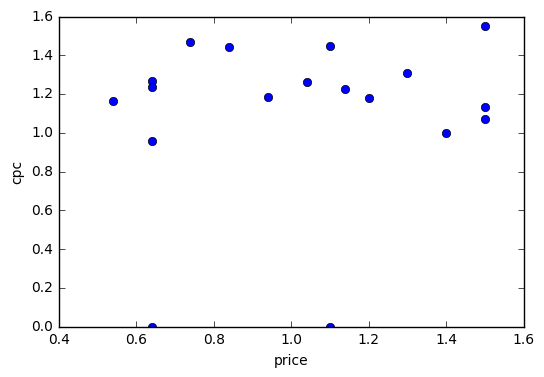

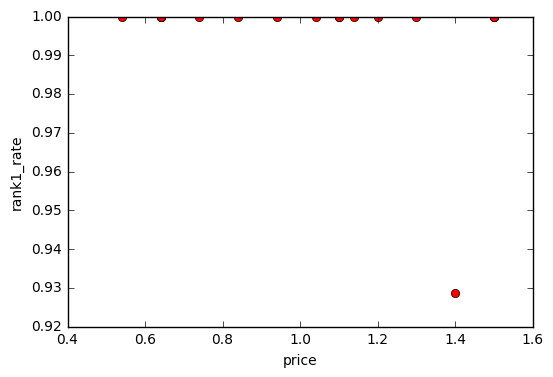

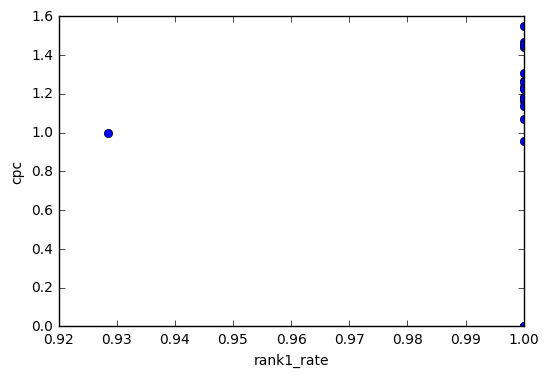

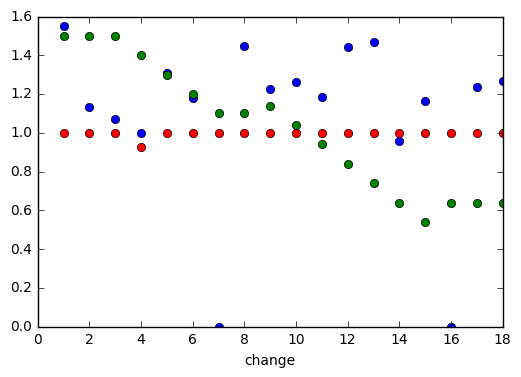

移动无限流量 2016-10-10 17:42:32 0.66 3811 117 123.91 3.07% 1.06 ['39', '14', '2', '0', '55'] 9
移动无限流量 2016-10-11 09:22:38 0.66 1513 36 39.28 2.38% 1.09 ['83', '66', '21', '0', '170'] 8
移动无限流量 2016-10-11 09:48:56 0.66 1704 38 41.42 2.23% 1.09 ['24', '16', '3', '0', '43'] 8
移动无限流量 2016-10-11 10:28:56 0.66 1815 41 44.5 2.26% 1.09 ['16', '7', '1', '0', '24'] 8
移动无限流量 2016-10-11 11:08:57 0.56 2011 47 51.64 2.34% 1.1 ['71', '36', '10', '0', '117'] 8
移动无限流量 2016-10-11 11:28:56 0.46 2075 54 57.98 2.60% 1.07 ['3', '7', '1', '0', '11'] 8
移动无限流量 2016-10-11 12:08:56 0.36 2122 57 60.01 2.69% 1.05 ['11', '12', '4', '0', '27'] 8
移动无限流量 2016-10-11 12:28:56 0.46 2137 58 60.85 2.71% 1.05 ['1', '0', '1', '0', '2'] 8
移动无限流量 2016-10-11 13:08:56 0.56 2186 58 60.85 2.65% 1.05 ['14', '10', '6', '0', '30'] 8
移动无限流量 2016-10-11 13:28:57 0.56 2292 60 62.94 2.62% 1.05 ['1', '2', '0', '0', '3'] 8
移动无限流量 2016-10-11 14:08:56 0.6 2419 65 68.25 2.69% 1.05 ['38', '42', '9', '0', '89'] 8
移动无限流量 2016-10-11 14:48:57 0.5 2493 67

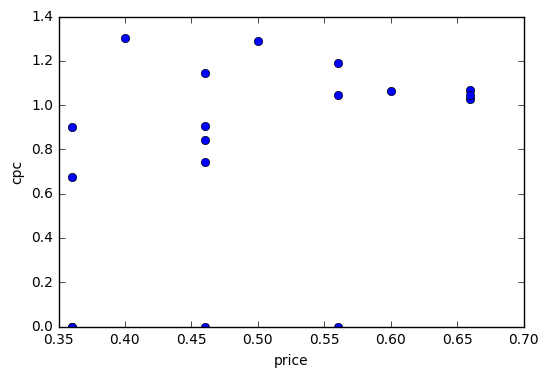

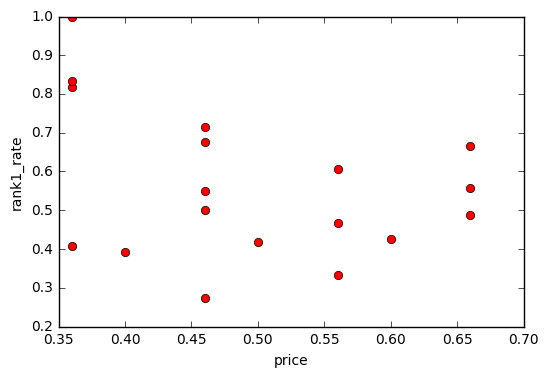

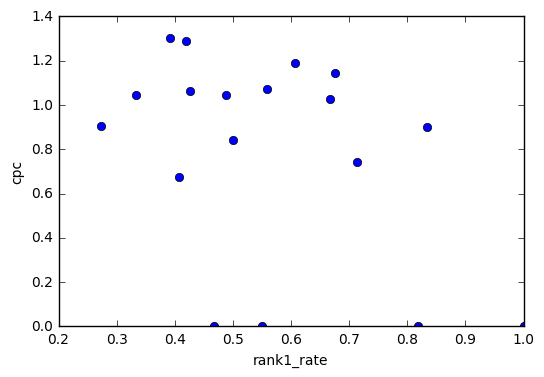

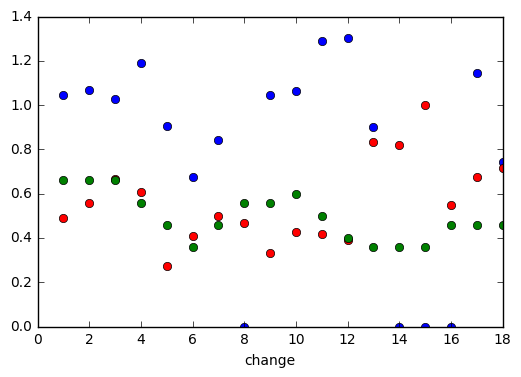

微会 2016-10-10 17:42:32 1.51 296 53 74.11 17.91% 1.4 ['11', '0', '0', '0', '11'] 8
微会 2016-10-11 09:22:38 1.51 98 12 14.25 12.24% 1.19 ['21', '0', '0', '0', '21'] 8
微会 2016-10-11 09:48:56 1.51 110 16 19.08 14.55% 1.19 ['7', '1', '0', '0', '8'] 8
微会 2016-10-11 10:28:56 1.51 127 17 19.83 13.39% 1.17 ['5', '0', '0', '0', '5'] 8
微会 2016-10-11 11:08:57 1.41 145 21 25.59 14.48% 1.22 ['24', '0', '0', '0', '24'] 8
微会 2016-10-11 11:28:56 1.51 161 22 27.05 13.66% 1.23 ['3', '0', '0', '0', '3'] 8
微会 2016-10-11 12:08:57 1.41 174 22 27.05 12.64% 1.23 ['24', '0', '0', '0', '24'] 8
微会 2016-10-11 12:28:56 1.41 191 25 29.98 13.09% 1.2 ['4', '0', '0', '0', '4'] 8
微会 2016-10-11 13:08:56 1.45 212 32 37.89 15.09% 1.18 ['19', '1', '0', '0', '20'] 8
微会 2016-10-11 13:28:57 1.55 237 37 43.39 15.61% 1.17 ['42', '3', '0', '0', '45'] 8
微会 2016-10-11 14:08:56 1.45 258 43 52.12 16.67% 1.21 ['21', '0', '0', '0', '21'] 8
微会 2016-10-11 14:48:57 1.35 272 44 52.74 16.18% 1.2 ['9', '0', '0', '0', '9'] 8
微会 2016-10-11 15:0

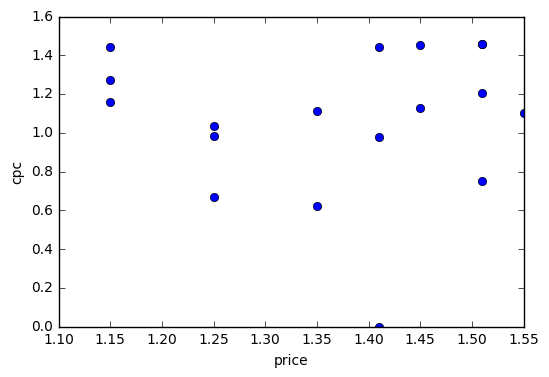

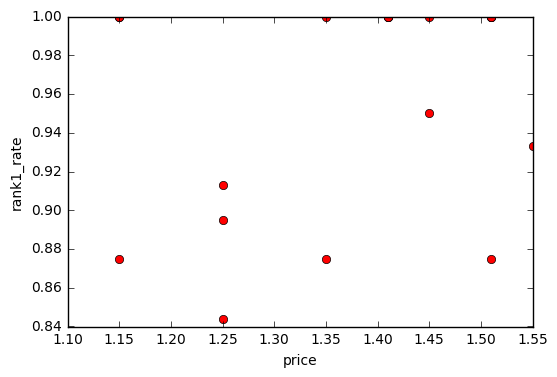

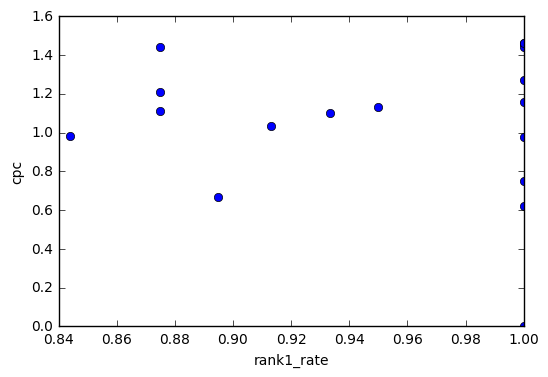

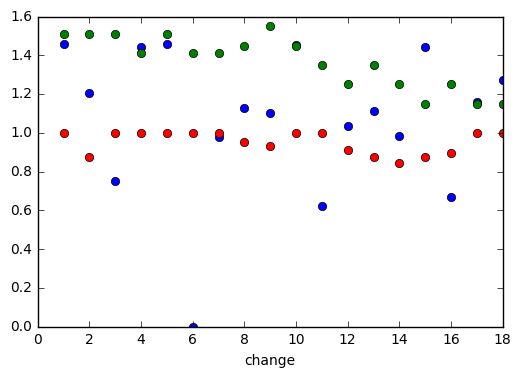

移动无限流量卡 2016-10-11 15:06:11 0.66 2036 35 41.26 1.72% 1.18 ['55', '55', '14', '0', '124'] 7
移动无限流量卡 2016-10-11 15:39:06 0.66 2231 36 42.24 1.61% 1.17 ['20', '13', '6', '0', '39'] 7
移动无限流量卡 2016-10-11 16:10:51 0.66 2386 44 50.19 1.84% 1.14 ['69', '44', '18', '0', '131'] 7
移动无限流量卡 2016-10-11 16:42:57 0.76 2493 49 57.08 1.97% 1.16 ['32', '20', '3', '0', '55'] 7
移动无限流量卡 2016-10-11 17:22:56 0.86 2686 53 60.95 1.97% 1.15 ['138', '98', '16', '0', '252'] 7
移动无限流量卡 2016-10-12 09:17:36 0.76 1339 37 45.23 2.76% 1.22 ['109', '70', '15', '0', '194'] 7
移动无限流量卡 2016-10-12 09:37:37 0.76 1502 43 51.57 2.86% 1.2 ['35', '16', '2', '0', '53'] 7
0


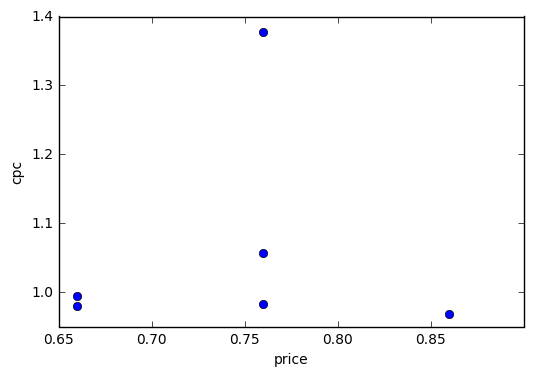

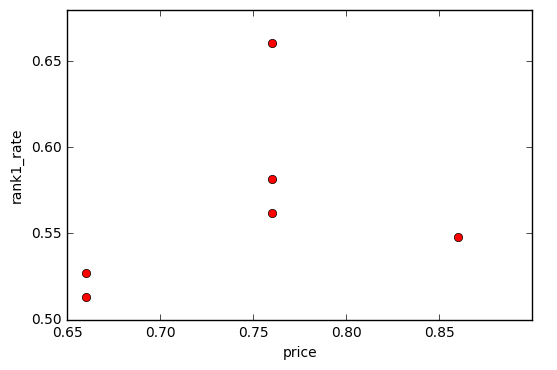

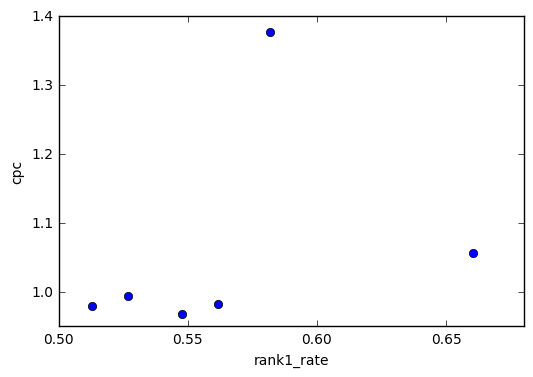

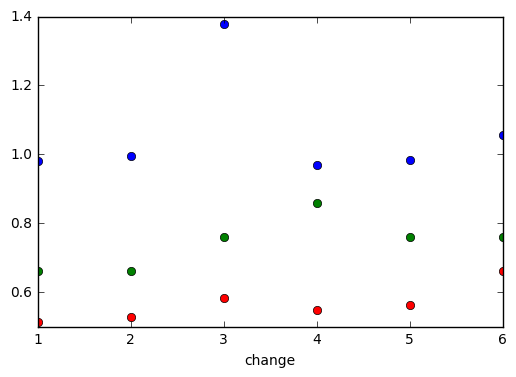

In [5]:
    for (appid,kid) in WDS:
        data_ori = []
        for i in c.find({'kw_id':kid}):
            time_created = i['date']
            if type(time_created) == datetime.datetime:
                continue
            if not i['rank_report']:
                continue
                
            if type(i['rank_report']) == dict:
                ranks = i['rank_report']['kpis']
            else:
                ranks = i['rank_report'][-1]['kpis']
            
            # the original data for one catch
            print(i['price_report']['keyword'],
                  i['date'],
                  i['price_report']['price'],
                  i['fujia_report']['button']['展现'],
                  i['fujia_report']['button']['点击'],
                  i['fujia_report']['button']['消费'],
                  i['fujia_report']['button']['点击率'],
                  i['fujia_report']['button']['平均点击价格'],
                  ranks,
                  i['price_report']['mobileQuality'],
                 )
            
            # the main structure, when new field added, please append it.
            data_ori.append((time_created,
                        i['price_report']['price'],
                        i['fujia_report']['button']['展现'],
                        i['fujia_report']['button']['点击'],
                        i['fujia_report']['button']['消费'],
                        ranks[0],
                        ranks[1],
                        ranks[2],
                        ranks[3],
                        ranks[4],
                        i['price_report']['keyword'],
                        i['price_report']['keywordId'],
                        i['price_report']['campaignId'],
                        i['price_report']['adgroupId'],
                        i['price_report']['matchType'],
                        i['price_report']['mobileQuality'],
                        ))
            
        # for now, data_ori is all the datas for one keyword
        if len(data_ori) < 2:
            continue
        
        #
        # then, we compare two snapshot to create one range state
        #
        change = []
        price = []
        cpc = []
        rank1 = []
        impression = []
        click = []
        cost = []
        
        print(data_ori[0][8])
        i = len(data_ori)-1
        while i > 0:
            d_cur = data_ori[i]
            d_pre = data_ori[i-1]
            
            # if the two impression is same, then ignore it
            if d_cur[2] == d_pre[2]:
                i -= 1
                continue
            
            # set the states
            i_time = d_cur[0]
            i_price = d_cur[1]
            #i_time_range = get_time_range(d_cur[0],d_pre[0])
            
            i_impression = int(d_cur[2] - d_pre[2])
            i_click = int(d_cur[3] - d_pre[3])
            i_cost= float(d_cur[4] - d_pre[4])
            
            if i_click != 0:
                i_cpc = i_cost / i_click
            else:
                i_cpc = 0
            
            if int(d_cur[9]) != 0:
                i_rank1_rate = float(int(d_cur[5]) / int(d_cur[9]))
            else:
                i_rank1_rate = 0
    
            if SHOW:
                change.append(i)
                
                price.append(i_price)
                cpc.append(i_cpc)
                rank1.append(i_rank1_rate)
                impression.append(i_impression)
                click.append(i_click)
                cost.append(i_cost)
            
            i -= 1
                
        # then show the graph
        #print('aaaa',price)
        if SHOW:
            if True:
                plt.plot(price, cpc,'ob')
                plt.xlabel('price')
                plt.ylabel('cpc')
                plt.show()
            if True:
                plt.plot(price, rank1,'or')
                plt.xlabel('price')
                plt.ylabel('rank1_rate')
                plt.show()
            if True:
                plt.plot(rank1, cpc,'ob')
                plt.xlabel('rank1_rate')
                plt.ylabel('cpc')
                plt.show()
            if True:
                plt.plot(change, cpc,'ob',change, rank1,'or',change, price,'og')
                plt.xlabel('change')
                #plt.ylabel('cpc')
                plt.show()
        #break